# Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

/Users/yujunlu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
csv_files = glob.glob('*.csv')
csv_files

['united-states-inflation-rate-cpi.csv',
 'USDGBP=X_true.csv',
 'USDEUR=X_true.csv',
 'USDEUR=X.csv',
 'oilprice.csv',
 'dowjones.csv',
 'goldprice.csv',
 'USDCHF=X_true.csv',
 'FEDFUNDS.csv',
 'USDCHF=X.csv',
 'USDGBP=X.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']

In [4]:
df_train=[]
df_test=[]
df_raw=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    # Somehow USDCHF=X.csv has one more day 2023/11/4, which shouldn't exist.
    if (path=='USDCHF=X.csv'):
        df_temp.drop(df_temp.index[-1], inplace=True)
    df_raw.append(df_temp)
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

In [5]:
for i in range(3):
    print(len(df_raw[i]))

2610
2610
2610


In [6]:
# There is something wrong with the files downloaded from the website.
# These rows shouldn't be nan.
# In this case, we simply adopt a strategy of dropping these rows.
# 2017/7/11 2017/11/16 2019/5/22
for i in range(len(filepath)):
    rows_with_nan = df_train[0][df_train[0].isna().any(axis=1)].index
    print(rows_with_nan)
for i in range(len(filepath)):
    df_train[i]=df_train[i].dropna()



Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')


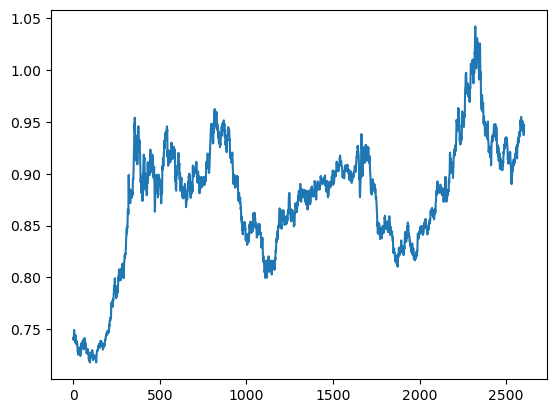

In [7]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [8]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [9]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(len(filepath)):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.21904042654002703
p-value=0.0
1:
p-value=0.34250452038892615
p-value=0.0
2:
p-value=0.046681409610507034
p-value=0.0


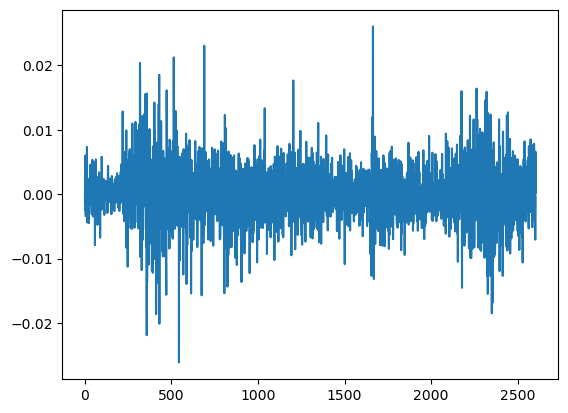

In [10]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

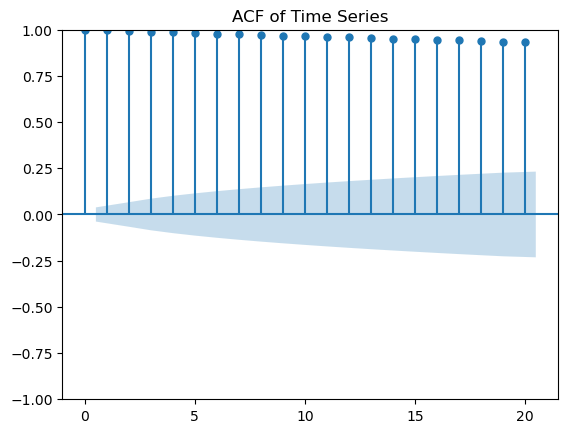

/Users/yujunlu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


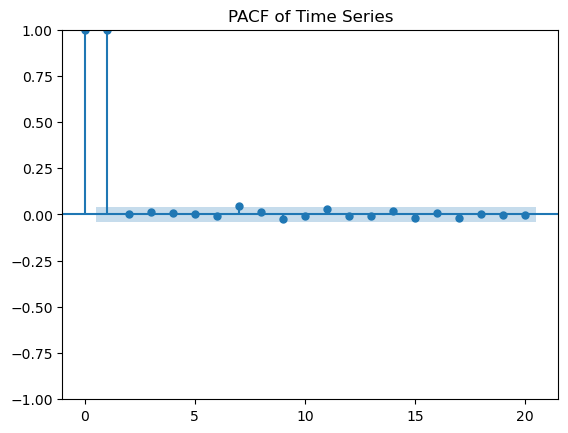

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

## Read in gold price 

In [12]:
gold_df = pd.read_csv("goldprice.csv")
# Set the 'date' column as the index
gold_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_gold_df = gold_df.loc['2013-11-04':'2023-11-03']
# Apply linear interpolation for NaN values
selected_gold_df_interpolated = selected_gold_df.interpolate(method='linear')
selected_gold_df_interpolated = selected_gold_df_interpolated.reset_index()
selected_gold_df_interpolated["date"]

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2559    2023-10-30
2560    2023-10-31
2561    2023-11-01
2562    2023-11-02
2563    2023-11-03
Name: date, Length: 2564, dtype: object

In [13]:
# First get the dates from currency 
df_temp=pd.read_csv("USDGBP=X.csv")
df_temp = df_temp.rename(columns={'Date': 'date'})
df_temp['date'] = pd.to_datetime(df_temp['date'])
dates_to_remove = pd.to_datetime(['2017-07-11', '2017-11-16', '2019-05-22'])
df_temp = df_temp[~df_temp['date'].isin(dates_to_remove)]
selected_gold_df_interpolated['date'] = pd.to_datetime(selected_gold_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_gold_df_interpolated, on='date', how='left')

merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

merged_df[" value"]

0       1314.2500
1       1311.2500
2       1317.0000
3       1316.0000
4       1309.0000
          ...    
2602    1996.0976
2603    1984.0109
2604    1984.4608
2605    1984.1135
2606    1992.2804
Name:  value, Length: 2607, dtype: float64

In [14]:
gold_price = merged_df[" value"].values
gold_price.shape # Same length as currency exchange history 

(2607,)

## Read in oil price 

In [15]:
oil_df = pd.read_csv("oilprice.csv")
# Set the 'date' column as the index
oil_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_oil_df = oil_df.loc['2013-11-04':'2023-11-03']
# Apply linear interpolation for NaN values
selected_oil_df_interpolated = selected_oil_df.interpolate(method='linear')
selected_oil_df_interpolated = selected_oil_df_interpolated.reset_index()
selected_oil_df_interpolated["date"]

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2532    2023-10-30
2533    2023-10-31
2534    2023-11-01
2535    2023-11-02
2536    2023-11-03
Name: date, Length: 2537, dtype: object

In [16]:
selected_oil_df_interpolated['date'] = pd.to_datetime(selected_oil_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_oil_df_interpolated, on='date', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

oil_price = merged_df[" value"].values
oil_price.shape # Same length as currency exchange history 


(2607,)

## Read in stock value

In [17]:
stock_df = pd.read_csv("dowjones.csv")
# Set the 'date' column as the index
stock_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_stock_df = oil_df.loc['2013-11-04':'2023-11-03']
# 2017/7/11 2017/11/16 2019/5/22
# Apply linear interpolation for NaN values
selected_stock_df_interpolated = selected_stock_df.interpolate(method='linear')
selected_stock_df_interpolated = selected_stock_df_interpolated.reset_index()
selected_stock_df_interpolated["date"] 

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2532    2023-10-30
2533    2023-10-31
2534    2023-11-01
2535    2023-11-02
2536    2023-11-03
Name: date, Length: 2537, dtype: object

In [18]:
selected_stock_df_interpolated['date'] = pd.to_datetime(selected_stock_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_stock_df_interpolated, on='date', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

stock_price = merged_df[" value"].values
stock_price.shape # Same length as currency exchange history 

(2607,)

# Prophet

In [12]:
# !pip3 install prophet 
# !pip3 install --upgrade plotly
# !pip3 install pandas_market_calendars
# !pip3 install --upgrade pandas
# from prophet import Prophet
# from datetime import datetime, timedelta
# import matplotlib.pyplot as plt
# from sklearn.model_selection import ParameterGrid

In [13]:
# # As prophet needs datetime and numeric value as input, I will re-process the input data here
# filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']
# df_train_prophet=[]
# df_test_prophet=[]
# df_all_prophet = []
# for path in filepath:
#     df_temp=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
#     df_temp = df_temp.rename(columns={"Date": "ds", "High": "y"})
#     df_train_prophet.append(df_temp[:-5])
#     df_test_prophet.append(df_temp[-5:])
#     df_all_prophet.append(df_temp)

In [14]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360
2603,2023-10-26,0.950000


In [15]:
df_test_prophet[0]

,ds,y
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94480
2609,2023-11-03,0.94202


In [16]:
# prophet_models = []

# for curve_data in df_train_prophet:
#     model = Prophet()
#     model.fit(curve_data)

#     last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
#     # Create a date range for the next 5 trading days, excluding weekends
#     future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
#     # Create a DataFrame with these dates
#     future_df = pd.DataFrame({'ds': future_dates})
#     # Make predictions
#     forecast = model.predict(future_df)
#     # Store the model and its forecast in a list
#     prophet_models.append((model, forecast))

20:08:27 - cmdstanpy - INFO - Chain [1] start processing
20:08:27 - cmdstanpy - INFO - Chain [1] done processing
20:08:28 - cmdstanpy - INFO - Chain [1] start processing
20:08:28 - cmdstanpy - INFO - Chain [1] done processing
20:08:28 - cmdstanpy - INFO - Chain [1] start processing
20:08:29 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-30,0.959745,0.934106,0.992069,0.959745,0.959745,0.003372,0.003372,0.003372,-0.000739,-0.000739,-0.000739,0.004111,0.004111,0.004111,0.0,0.0,0.0,0.963117
1,2023-10-31,0.959813,0.935011,0.991945,0.959813,0.959813,0.003975,0.003975,0.003975,-0.000566,-0.000566,-0.000566,0.004541,0.004541,0.004541,0.0,0.0,0.0,0.963788
2,2023-11-01,0.959882,0.937794,0.992920,0.959882,0.959882,0.004414,0.004414,0.004414,-0.000585,-0.000585,-0.000585,0.004999,0.004999,0.004999,0.0,0.0,0.0,0.964295
3,2023-11-02,0.959950,0.935400,0.993302,0.959950,0.959950,0.005225,0.005225,0.005225,-0.000250,-0.000250,-0.000250,0.005475,0.005475,0.005475,0.0,0.0,0.0,0.965175
4,2023-11-03,0.960018,0.939205,0.993446,0.960018,0.960018,0.005803,0.005803,0.005803,-0.000161,-0.000161,-0.000161,0.005964,0.005964,0.005964,0.0,0.0,0.0,0.965822


## Calculate Errors For Prediction

In [18]:
# errors = []
# def calculate_mse(truth, prediction):
#     """ 
#     truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
#     """
#     errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
#     return errors, np.sum(errors)

# calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0034678570831605015, 0.010102703406414788, 0.0023839275206320684],
 0.01595448801020736)

## Plot the ground truth and prediction

In [19]:
# def draw_pred_truth(truth, pred):
#     fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
#     for i in range(len(filepath)):
#         ax = axes[i]
#         ax.plot(truth[i], label='Truth')
#         ax.plot(pred[i], label='Pred')
#         ax.set_title(f'Plot {i + 1}')
#         ax.legend()
#         ax.grid()
#     plt.tight_layout()
#     plt.show()

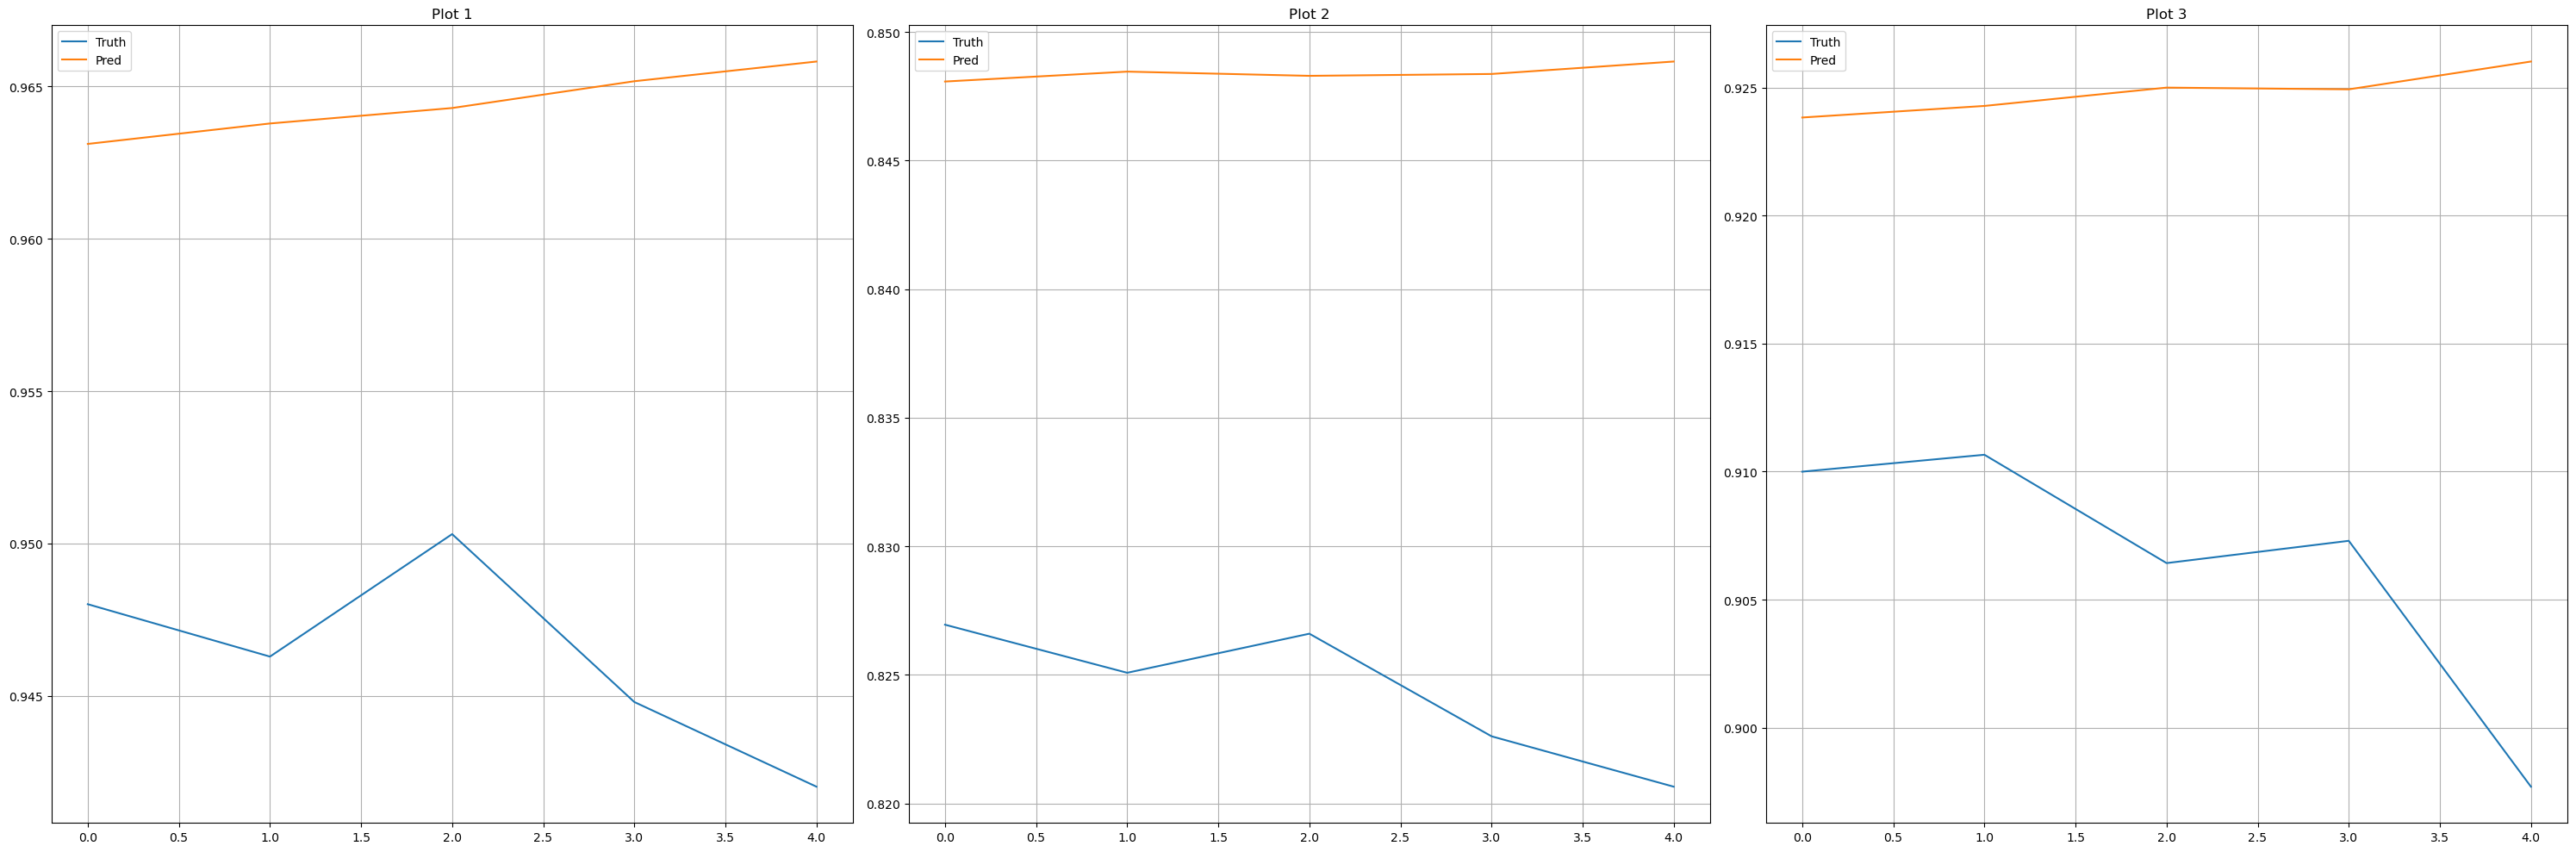

In [20]:
# truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
# pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
# draw_pred_truth(truth_prophet, pred_prophet)

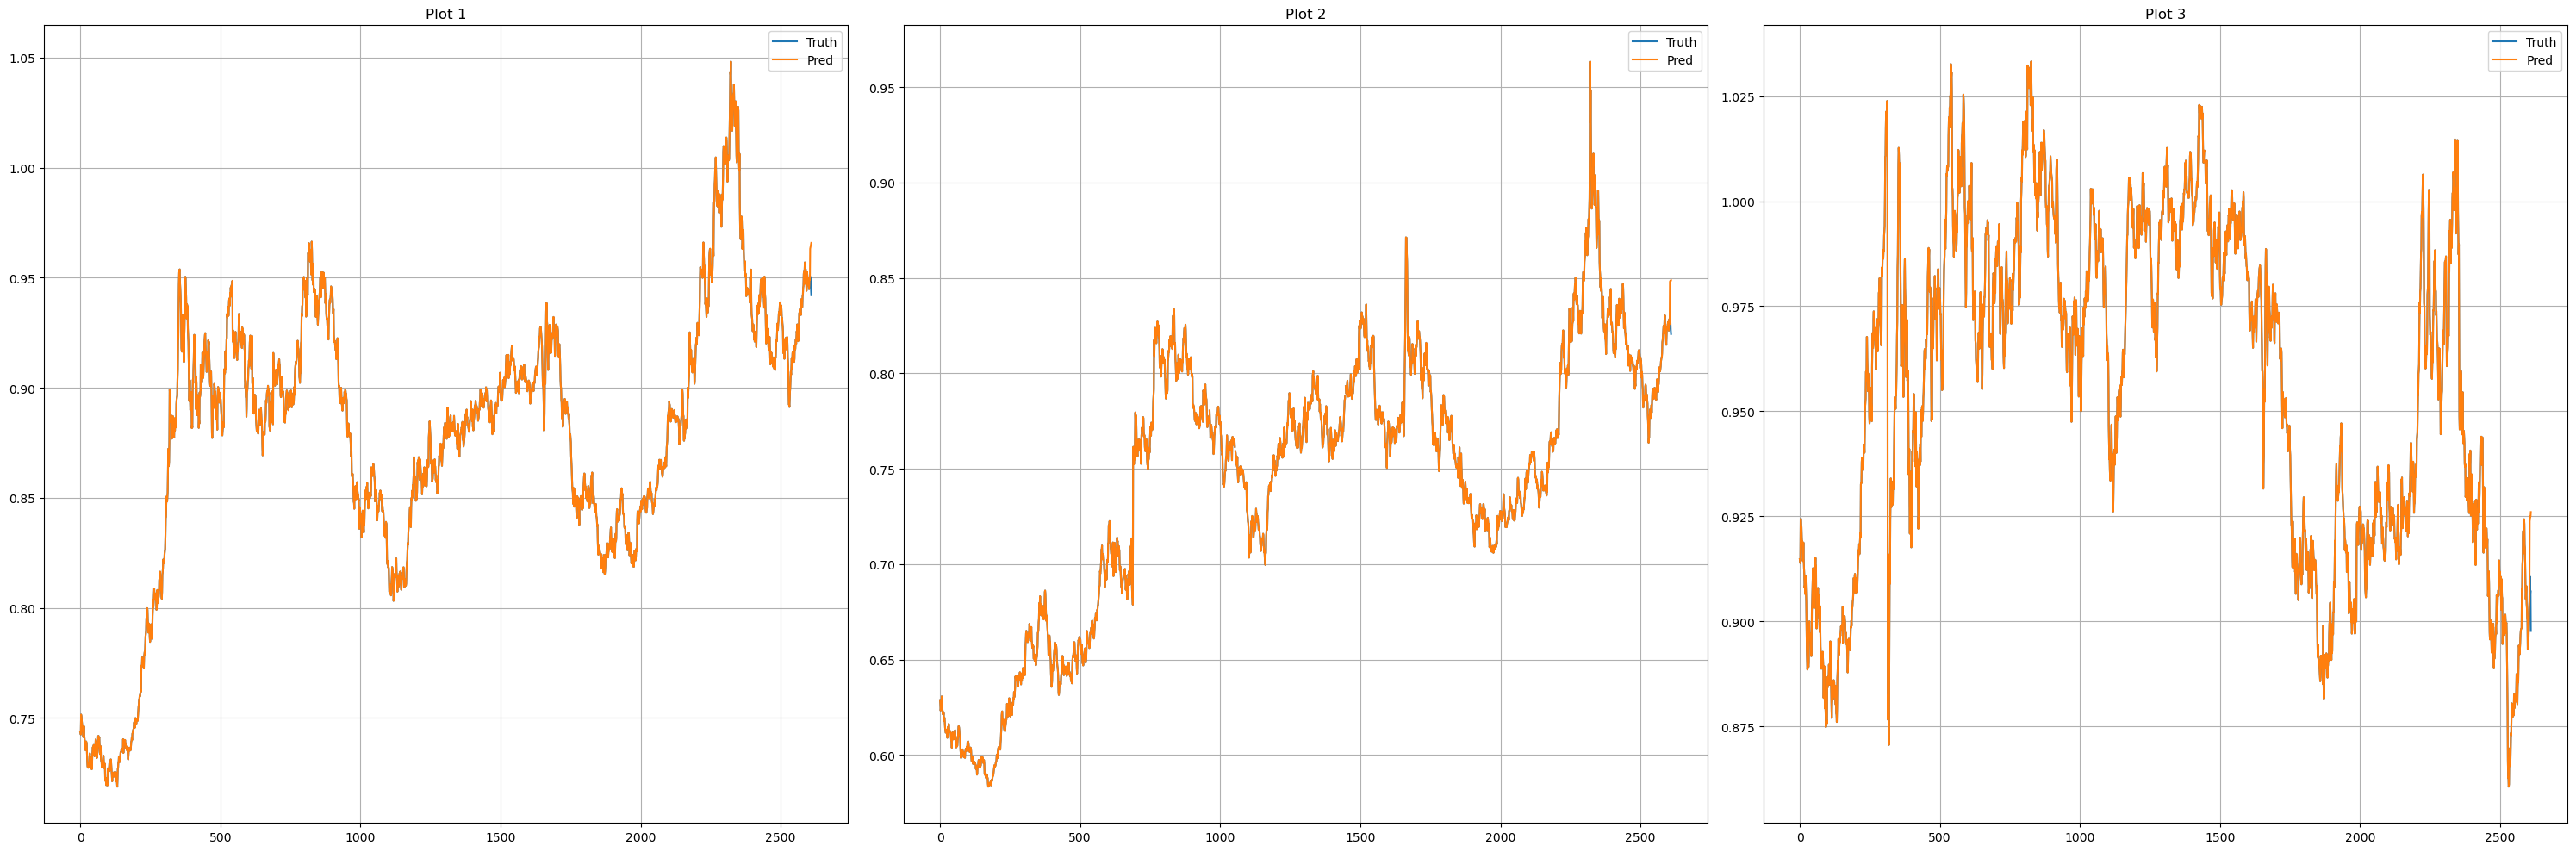

In [21]:
# train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# # print(len(train_pred_prophet))
# draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)

## Hyper parameter tunning to find the best model

In [22]:
# # Define a range of hyperparameter values to search
# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
# }
# best_mse = float('inf')
# best_params = {}
# ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# # Iterate through the parameter grid and find the best hyperparameters
# for params in ParameterGrid(param_grid):
#     print(f"params is {params}")
#     para_models = []
#     for curve_data in df_train_prophet:
#         # Create a Prophet model with the current hyperparameters
#         model = Prophet(
#             changepoint_prior_scale=params['changepoint_prior_scale'],
#             seasonality_prior_scale=params['seasonality_prior_scale'],
#             holidays_prior_scale=params['holidays_prior_scale']
#         )
        
#         # Fit the model on the training data
#         model.fit(curve_data)
        
#         last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
#         # Create a date range for the next 5 trading days, excluding weekends
#         future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
#         # Create a DataFrame with these dates
#         future_df = pd.DataFrame({'ds': future_dates})
#         # Make predictions
#         forecast = model.predict(future_df)

#         para_models.append((model, forecast))
#     _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
#     print(f"MSE is {mse}")
#     # Check if the current set of hyperparameters results in a better model
#     if mse < best_mse:
#         best_mse = mse
#         best_params = params

# print("Best Hyperparameters:")
# print(best_params)
# print("Best MSE:", best_mse)

params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:08:30 - cmdstanpy - INFO - Chain [1] start processing
20:08:30 - cmdstanpy - INFO - Chain [1] done processing
20:08:31 - cmdstanpy - INFO - Chain [1] start processing
20:08:31 - cmdstanpy - INFO - Chain [1] done processing
20:08:31 - cmdstanpy - INFO - Chain [1] start processing
20:08:31 - cmdstanpy - INFO - Chain [1] done processing
20:08:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:33 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:33 - cmdstanpy - INFO - Chain [1] done processing
20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:34 - cmdstanpy - INFO - Chain [1] done processing
20:08:34 - cmdstanpy - INFO - Chain [1] start processing
20:08:34 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:08:34 - cmdstanpy - INFO - Chain [1] start processing
20:08:35 - cmdstanpy - INFO - Chain [1] done processing
20:08:35 - cmdstanpy - INFO - Chain [1] start processing
20:08:35 - cmdstanpy - INFO - Chain [1] done processing
20:08:35 - cmdstanpy - INFO - Chain [1] start processing
20:08:35 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:08:36 - cmdstanpy - INFO - Chain [1] start processing
20:08:36 - cmdstanpy - INFO - Chain [1] done processing
20:08:36 - cmdstanpy - INFO - Chain [1] start processing
20:08:36 - cmdstanpy - INFO - Chain [1] done processing
20:08:37 - cmdstanpy - INFO - Chain [1] start processing
20:08:37 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:08:37 - cmdstanpy - INFO - Chain [1] start processing
20:08:37 - cmdstanpy - INFO - Chain [1] done processing
20:08:37 - cmdstanpy - INFO - Chain [1] start processing
20:08:38 - cmdstanpy - INFO - Chain [1] done processing
20:08:38 - cmdstanpy - INFO - Chain [1] start processing
20:08:38 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:08:38 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:40 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:08:40 - cmdstanpy - INFO - Chain [1] start processing
20:08:40 - cmdstanpy - INFO - Chain [1] done processing
20:08:40 - cmdstanpy - INFO - Chain [1] start processing
20:08:41 - cmdstanpy - INFO - Chain [1] done processing
20:08:41 - cmdstanpy - INFO - Chain [1] start processing
20:08:41 - cmdstanpy - INFO - Chain [1] done processing
20:08:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:08:42 - cmdstanpy - INFO - Chain [1] done processing
20:08:42 - cmdstanpy - INFO - Chain [1] start processing
20:08:42 - cmdstanpy - INFO - Chain [1] done processing
20:08:42 - cmdstanpy - INFO - Chain [1] start processing
20:08:42 - cmdstanpy - INFO - Chain [1] done processing
20:08:43 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:08:43 - cmdstanpy - INFO - Chain [1] done processing
20:08:43 - cmdstanpy - INFO - Chain [1] start processing
20:08:43 - cmdstanpy - INFO - Chain [1] done processing
20:08:44 - cmdstanpy - INFO - Chain [1] start processing
20:08:44 - cmdstanpy - INFO - Chain [1] done processing
20:08:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:08:45 - cmdstanpy - INFO - Chain [1] done processing
20:08:45 - cmdstanpy - INFO - Chain [1] start processing
20:08:45 - cmdstanpy - INFO - Chain [1] done processing
20:08:45 - cmdstanpy - INFO - Chain [1] start processing
20:08:45 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:47 - cmdstanpy - INFO - Chain [1] start processing
20:08:47 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:08:47 - cmdstanpy - INFO - Chain [1] start processing
20:08:47 - cmdstanpy - INFO - Chain [1] done processing
20:08:48 - cmdstanpy - INFO - Chain [1] start processing
20:08:48 - cmdstanpy - INFO - Chain [1] done processing
20:08:48 - cmdstanpy - INFO - Chain [1] start processing
20:08:48 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:08:48 - cmdstanpy - INFO - Chain [1] start processing
20:08:49 - cmdstanpy - INFO - Chain [1] done processing
20:08:49 - cmdstanpy - INFO - Chain [1] start processing
20:08:49 - cmdstanpy - INFO - Chain [1] done processing
20:08:49 - cmdstanpy - INFO - Chain [1] start processing
20:08:50 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:08:50 - cmdstanpy - INFO - Chain [1] start processing
20:08:50 - cmdstanpy - INFO - Chain [1] done processing
20:08:50 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] done processing
20:08:51 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:08:51 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] done processing
20:08:52 - cmdstanpy - INFO - Chain [1] start processing
20:08:52 - cmdstanpy - INFO - Chain [1] done processing
20:08:52 - cmdstanpy - INFO - Chain [1] start processing
20:08:52 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:54 - cmdstanpy - INFO - Chain [1] done processing
20:08:54 - cmdstanpy - INFO - Chain [1] start processing
20:08:55 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:08:55 - cmdstanpy - INFO - Chain [1] start processing
20:08:55 - cmdstanpy - INFO - Chain [1] done processing
20:08:56 - cmdstanpy - INFO - Chain [1] start processing
20:08:56 - cmdstanpy - INFO - Chain [1] done processing
20:08:56 - cmdstanpy - INFO - Chain [1] start processing
20:08:57 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:08:57 - cmdstanpy - INFO - Chain [1] start processing
20:08:58 - cmdstanpy - INFO - Chain [1] done processing
20:08:58 - cmdstanpy - INFO - Chain [1] start processing
20:08:58 - cmdstanpy - INFO - Chain [1] done processing
20:08:59 - cmdstanpy - INFO - Chain [1] start processing
20:08:59 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing
20:09:01 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:09:01 - cmdstanpy - INFO - Chain [1] start processing
20:09:02 - cmdstanpy - INFO - Chain [1] done processing
20:09:02 - cmdstanpy - INFO - Chain [1] start processing
20:09:03 - cmdstanpy - INFO - Chain [1] done processing
20:09:03 - cmdstanpy - INFO - Chain [1] start processing
20:09:03 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:09:04 - cmdstanpy - INFO - Chain [1] start processing
20:09:04 - cmdstanpy - INFO - Chain [1] done processing
20:09:04 - cmdstanpy - INFO - Chain [1] start processing
20:09:05 - cmdstanpy - INFO - Chain [1] done processing
20:09:05 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:07 - cmdstanpy - INFO - Chain [1] start processing
20:09:07 - cmdstanpy - INFO - Chain [1] done processing
20:09:07 - cmdstanpy - INFO - Chain [1] start processing
20:09:08 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:09:08 - cmdstanpy - INFO - Chain [1] start processing
20:09:09 - cmdstanpy - INFO - Chain [1] done processing
20:09:09 - cmdstanpy - INFO - Chain [1] start processing
20:09:09 - cmdstanpy - INFO - Chain [1] done processing
20:09:10 - cmdstanpy - INFO - Chain [1] start processing
20:09:10 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:09:10 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:12 - cmdstanpy - INFO - Chain [1] start processing
20:09:12 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:09:12 - cmdstanpy - INFO - Chain [1] start processing
20:09:13 - cmdstanpy - INFO - Chain [1] done processing
20:09:13 - cmdstanpy - INFO - Chain [1] start processing
20:09:14 - cmdstanpy - INFO - Chain [1] done processing
20:09:14 - cmdstanpy - INFO - Chain [1] start processing
20:09:14 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:09:15 - cmdstanpy - INFO - Chain [1] start processing
20:09:15 - cmdstanpy - INFO - Chain [1] done processing
20:09:15 - cmdstanpy - INFO - Chain [1] start processing
20:09:16 - cmdstanpy - INFO - Chain [1] done processing
20:09:16 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:18 - cmdstanpy - INFO - Chain [1] done processing
20:09:18 - cmdstanpy - INFO - Chain [1] start processing
20:09:18 - cmdstanpy - INFO - Chain [1] done processing
20:09:19 - cmdstanpy - INFO - Chain [1] start processing
20:09:19 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:09:19 - cmdstanpy - INFO - Chain [1] start processing
20:09:20 - cmdstanpy - INFO - Chain [1] done processing
20:09:20 - cmdstanpy - INFO - Chain [1] start processing
20:09:20 - cmdstanpy - INFO - Chain [1] done processing
20:09:21 - cmdstanpy - INFO - Chain [1] start processing
20:09:21 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:09:21 - cmdstanpy - INFO - Chain [1] start processing
20:09:22 - cmdstanpy - INFO - Chain [1] done processing
20:09:22 - cmdstanpy - INFO - Chain [1] start processing
20:09:22 - cmdstanpy - INFO - Chain [1] done processing
20:09:23 - cmdstanpy - INFO - Chain [1] start processing
20:09:23 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:09:23 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:25 - cmdstanpy - INFO - Chain [1] done processing
20:09:25 - cmdstanpy - INFO - Chain [1] start processing
20:09:26 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:09:26 - cmdstanpy - INFO - Chain [1] start processing
20:09:26 - cmdstanpy - INFO - Chain [1] done processing
20:09:27 - cmdstanpy - INFO - Chain [1] start processing
20:09:27 - cmdstanpy - INFO - Chain [1] done processing
20:09:27 - cmdstanpy - INFO - Chain [1] start processing
20:09:28 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:09:28 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:30 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:31 - cmdstanpy - INFO - Chain [1] done processing
20:09:31 - cmdstanpy - INFO - Chain [1] start processing
20:09:32 - cmdstanpy - INFO - Chain [1] done processing
20:09:32 - cmdstanpy - INFO - Chain [1] start processing
20:09:33 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:09:33 - cmdstanpy - INFO - Chain [1] start processing
20:09:34 - cmdstanpy - INFO - Chain [1] done processing
20:09:34 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:36 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:09:36 - cmdstanpy - INFO - Chain [1] start processing
20:09:37 - cmdstanpy - INFO - Chain [1] done processing
20:09:37 - cmdstanpy - INFO - Chain [1] start processing
20:09:38 - cmdstanpy - INFO - Chain [1] done processing
20:09:38 - cmdstanpy - INFO - Chain [1] start processing
20:09:39 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:09:39 - cmdstanpy - INFO - Chain [1] start processing
20:09:40 - cmdstanpy - INFO - Chain [1] done processing
20:09:40 - cmdstanpy - INFO - Chain [1] start processing
20:09:40 - cmdstanpy - INFO - Chain [1] done processing
20:09:40 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:42 - cmdstanpy - INFO - Chain [1] done processing
20:09:42 - cmdstanpy - INFO - Chain [1] start processing
20:09:43 - cmdstanpy - INFO - Chain [1] done processing
20:09:43 - cmdstanpy - INFO - Chain [1] start processing
20:09:44 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:09:44 - cmdstanpy - INFO - Chain [1] start processing
20:09:45 - cmdstanpy - INFO - Chain [1] done processing
20:09:45 - cmdstanpy - INFO - Chain [1] start processing
20:09:46 - cmdstanpy - INFO - Chain [1] done processing
20:09:46 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:09:48 - cmdstanpy - INFO - Chain [1] done processing
20:09:48 - cmdstanpy - INFO - Chain [1] start processing
20:09:49 - cmdstanpy - INFO - Chain [1] done processing
20:09:49 - cmdstanpy - INFO - Chain [1] start processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:09:50 - cmdstanpy - INFO - Chain [1] start processing
20:09:51 - cmdstanpy - INFO - Chain [1] done processing
20:09:51 - cmdstanpy - INFO - Chain [1] start processing
20:09:51 - cmdstanpy - INFO - Chain [1] done processing
20:09:51 - cmdstanpy - INFO - Chain [1] start processing
20:09:52 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:09:52 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing
20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:55 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:09:55 - cmdstanpy - INFO - Chain [1] start processing
20:09:56 - cmdstanpy - INFO - Chain [1] done processing
20:09:57 - cmdstanpy - INFO - Chain [1] start processing
20:09:57 - cmdstanpy - INFO - Chain [1] done processing
20:09:57 - cmdstanpy - INFO - Chain [1] start processing
20:09:58 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:09:58 - cmdstanpy - INFO - Chain [1] start processing
20:09:59 - cmdstanpy - INFO - Chain [1] done processing
20:09:59 - cmdstanpy - INFO - Chain [1] start processing
20:10:00 - cmdstanpy - INFO - Chain [1] done processing
20:10:00 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:02 - cmdstanpy - INFO - Chain [1] done processing
20:10:02 - cmdstanpy - INFO - Chain [1] start processing
20:10:02 - cmdstanpy - INFO - Chain [1] done processing
20:10:03 - cmdstanpy - INFO - Chain [1] start processing
20:10:03 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:10:03 - cmdstanpy - INFO - Chain [1] start processing
20:10:04 - cmdstanpy - INFO - Chain [1] done processing
20:10:04 - cmdstanpy - INFO - Chain [1] start processing
20:10:05 - cmdstanpy - INFO - Chain [1] done processing
20:10:05 - cmdstanpy - INFO - Chain [1] start processing
20:10:06 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:10:06 - cmdstanpy - INFO - Chain [1] start processing
20:10:07 - cmdstanpy - INFO - Chain [1] done processing
20:10:07 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:09 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:10:09 - cmdstanpy - INFO - Chain [1] start processing
20:10:10 - cmdstanpy - INFO - Chain [1] done processing
20:10:10 - cmdstanpy - INFO - Chain [1] start processing
20:10:11 - cmdstanpy - INFO - Chain [1] done processing
20:10:11 - cmdstanpy - INFO - Chain [1] start processing
20:10:12 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Best MSE: 0.015295367119741509


In [23]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472

## Now predict using the best model 

20:10:12 - cmdstanpy - INFO - Chain [1] start processing
20:10:13 - cmdstanpy - INFO - Chain [1] done processing
20:10:13 - cmdstanpy - INFO - Chain [1] start processing
20:10:13 - cmdstanpy - INFO - Chain [1] done processing
20:10:14 - cmdstanpy - INFO - Chain [1] start processing
20:10:14 - cmdstanpy - INFO - Chain [1] done processing


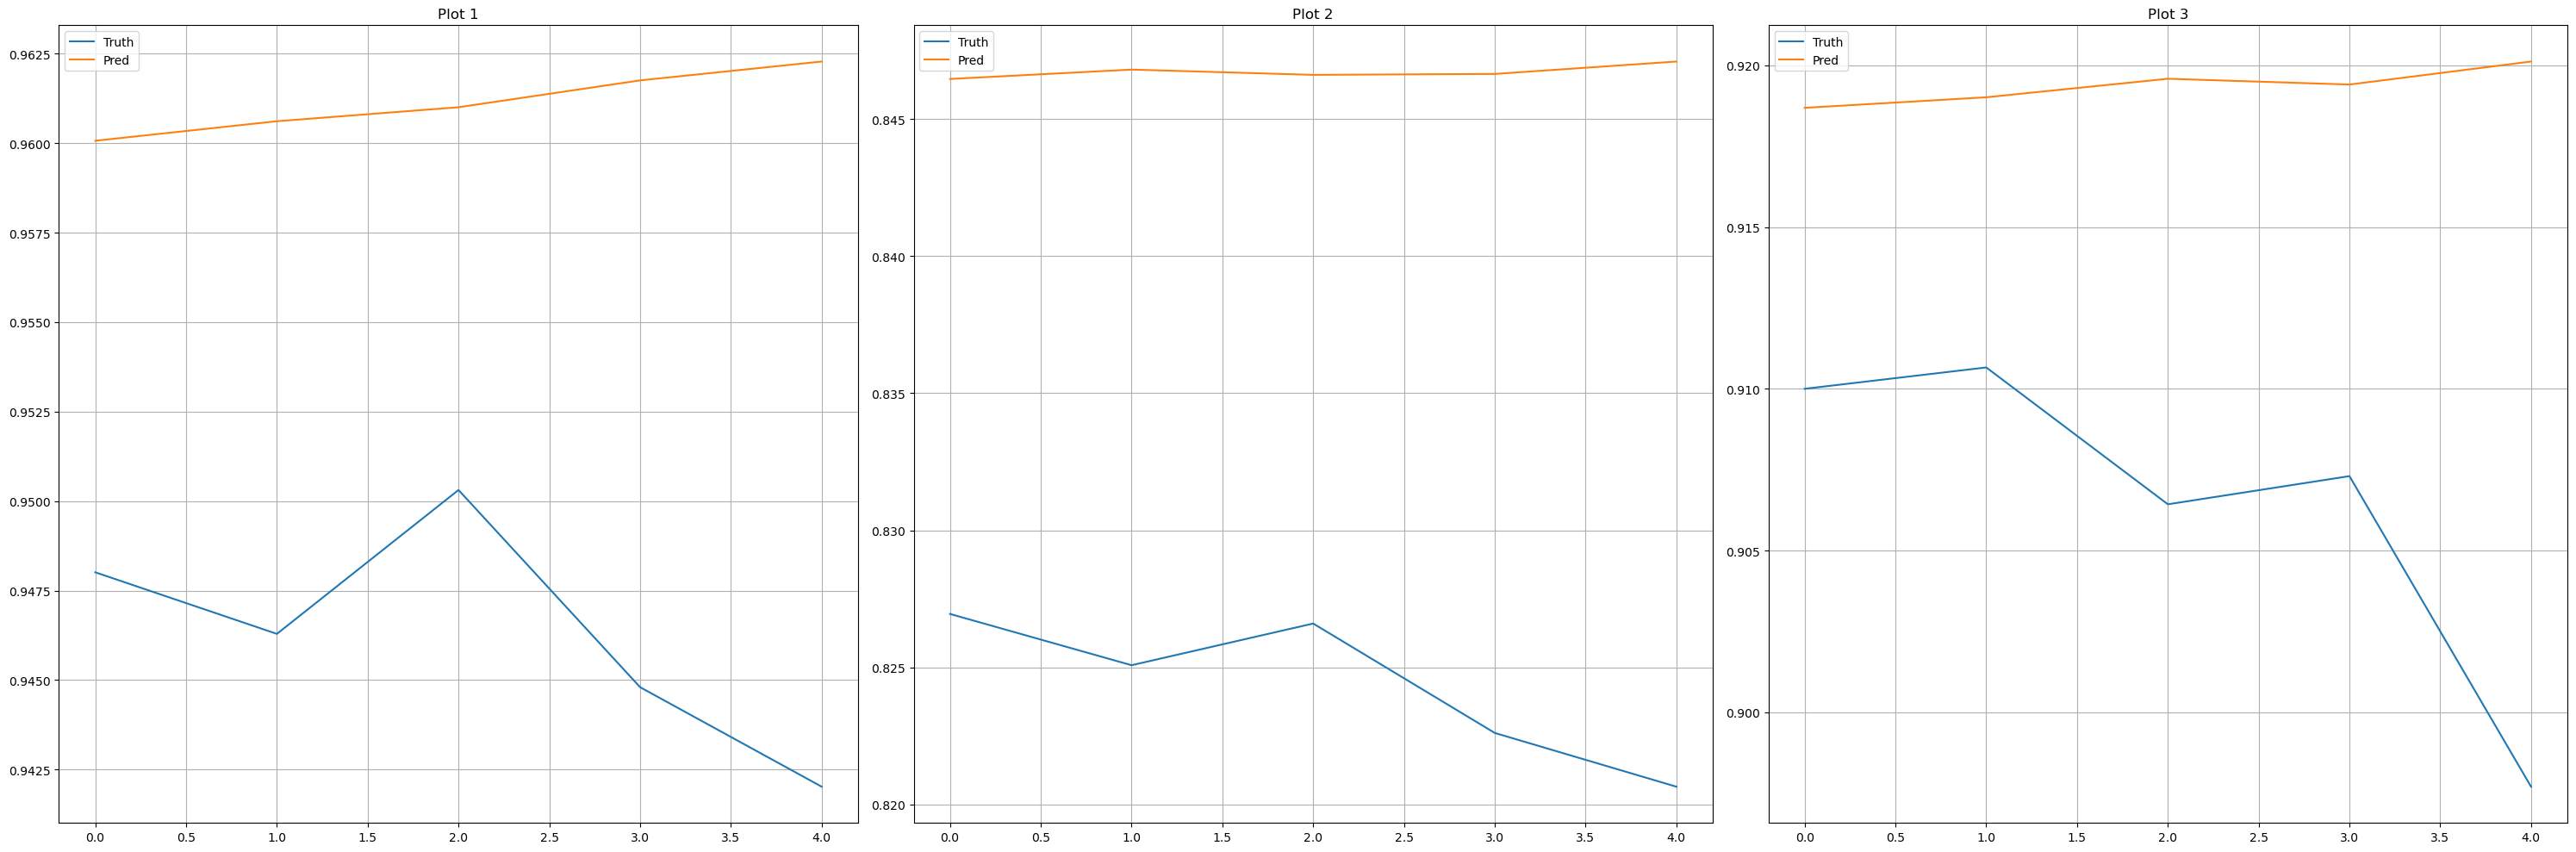

In [24]:
# prophet_models = []

# for curve_data in df_train_prophet:
#     model = Prophet(
#         changepoint_prior_scale=0.1,
#         seasonality_prior_scale=0.01,
#         holidays_prior_scale=0.1
#     )
#     model.fit(curve_data)

#     last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
#     # Create a date range for the next 5 trading days, excluding weekends
#     future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
#     # Create a DataFrame with these dates
#     future_df = pd.DataFrame({'ds': future_dates})
#     # Make predictions
#     forecast = model.predict(future_df)
#     # Store the model and its forecast in a list
#     prophet_models.append((model, forecast))

# truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
# pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
# draw_pred_truth(truth_prophet, pred_prophet)

# ARIMA

In [13]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [14]:
print(train.shape,val.shape)

(2597,) (5,)


In [15]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2597
Model:                 ARIMA(1, 2, 1)   Log Likelihood               10179.533
Date:                Sat, 09 Dec 2023   AIC                         -20353.066
Time:                        10:55:22   BIC                         -20335.482
Sample:                             0   HQIC                        -20346.695
                               - 2597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.020      0.169      0.866      -0.035       0.042
ma.L1         -0.7564      0.016    -46.935      0.000      -0.788      -0.725
sigma2      2.288e-05   4.43e-07     51.680      0.0

In [16]:
train

array([0.74107, 0.73981, 0.74222, ..., 0.9458 , 0.9489 , 0.9446 ])

In [17]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.111605   0.73855    0.7428708  ... 0.94543074 0.94939189 0.94389979]
[0.94389979 0.94321149 0.94252323 0.94183498 0.94114672]


In [18]:
val

array([0.94429, 0.93722, 0.94381, 0.94632, 0.94657])

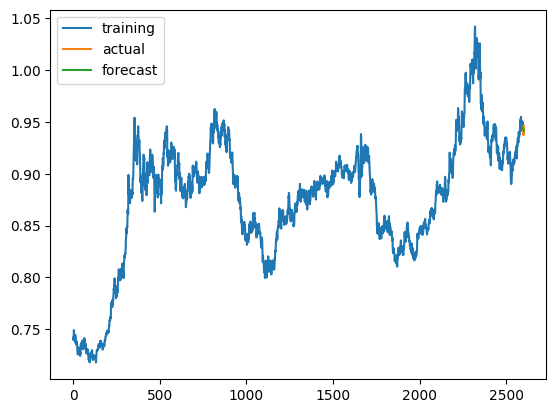

In [19]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

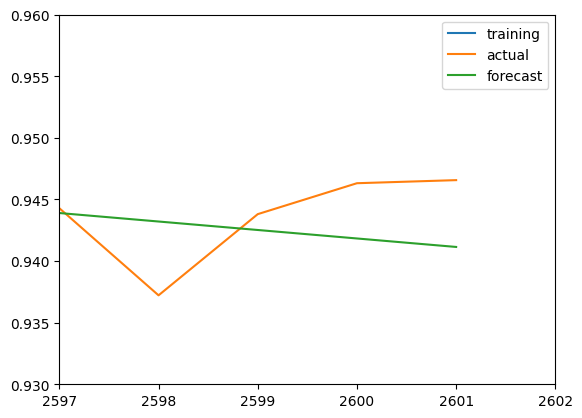

In [20]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.xlim(len(train), len(train)+len(val))
plt.ylim(0.93, 0.96)
plt.legend()

In [21]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 5.5470984806165804e-05
val_MSE: 1.744668848540088e-05


## Fine-tuning

In [22]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

p=1,d=1,q=1:
train_MSE: 5.6222814148842284e-08
val_MSE: 1.2565155350526682e-05
-------------------------------------------------------------
p=1,d=1,q=2:
train_MSE: 4.804952925488441e-09
val_MSE: 1.2490400324972694e-05
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 6.490424949203998e-09
val_MSE: 1.2451416385811145e-05
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 6.974655658789518e-09
val_MSE: 1.2455803487680617e-05
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 9.812872026217593e-09
val_MSE: 1.23860028074822e-05
-------------------------------------------------------------
p=1,d=2,q=1:
train_MSE: 5.5470984806165804e-05
val_MSE: 1.744668848540088e-05
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 5.444922593016741e-05
val_MSE: 1.381108325725283e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_MSE

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=2,d=1,q=2:
train_MSE: 1.0308505929660309e-08
val_MSE: 1.283124320335454e-05
-------------------------------------------------------------
p=2,d=1,q=3:
train_MSE: 6.33452171150614e-09
val_MSE: 1.2401980550901475e-05
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 7.69082141590808e-09
val_MSE: 1.2471527910867198e-05
-------------------------------------------------------------
p=2,d=1,q=5:
train_MSE: 1.0382692316241156e-08
val_MSE: 1.2328061681645358e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=1:
train_MSE: 5.291992107128736e-05
val_MSE: 1.2642306373188155e-05
-------------------------------------------------------------
p=2,d=2,q=2:
train_MSE: 5.451466717425703e-05
val_MSE: 1.4160193077047734e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=3:
train_MSE: 5.290669310736227e-05
val_MSE: 1.2448938726910449e-05
-------------------------------------------------------------
p=2,d=2,q=4:
train_MSE: 5.3663740764778745e-05
val_MSE: 1.2483918147014464e-05
-------------------------------------------------------------
p=2,d=2,q=5:
train_MSE: 5.35452132646711e-05
val_MSE: 1.252050444357281e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=1,q=1:
train_MSE: 1.0645112143001522e-18
val_MSE: 1.2404781065742911e-05
-------------------------------------------------------------
p=3,d=1,q=2:
train_MSE: 6.03252046804869e-08
val_MSE: 1.2441885704974039e-05
-------------------------------------------------------------
p=3,d=1,q=3:
train_MSE: 6.3243225734459004e-09
val_MSE: 1.2401515414159835e-05
-------------------------------------------------------------
p=3,d=1,q=4:
train_MSE: 7.288370529669175e-09
val_MSE: 1.2348049864931436e-05
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 1.0922985416718382e-08
val_MSE: 1.2238072530667396e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=1:
train_MSE: 5.3028244038681686e-05
val_MSE: 1.3251617563946991e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=2:
train_MSE: 5.294837243846555e-05
val_MSE: 1.2718625934971314e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=3:
train_MSE: 5.2908766747580835e-05
val_MSE: 1.2558215272556419e-05
-------------------------------------------------------------
p=3,d=2,q=4:
train_MSE: 5.367192369127105e-05
val_MSE: 1.2605127781010654e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=2,q=5:
train_MSE: 5.357017872119797e-05
val_MSE: 1.2202557312738311e-05
-------------------------------------------------------------
p=4,d=1,q=1:
train_MSE: 1.0075217286548163e-19
val_MSE: 1.240478025113697e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=2:
train_MSE: 6.256038593181408e-18
val_MSE: 1.240478250341097e-05
-------------------------------------------------------------
p=4,d=1,q=3:
train_MSE: 6.2624337002756375e-09
val_MSE: 1.2425736624772603e-05
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 8.904956742204097e-08
val_MSE: 1.1170487287606341e-05
-------------------------------------------------------------
p=4,d=1,q=5:
train_MSE: 1.2671070918737465e-08
val_MSE: 1.2047952988138419e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=1:
train_MSE: 5.403243307421771e-05
val_MSE: 1.7466761133631045e-05
-------------------------------------------------------------
p=4,d=2,q=2:
train_MSE: 5.38741602689767e-05
val_MSE: 1.3843685944292218e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=3:
train_MSE: 5.300699974013246e-05
val_MSE: 1.2685083893318588e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 5.3057871674710714e-05
val_MSE: 1.2808780056111278e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=2,q=5:
train_MSE: 5.302963494998327e-05
val_MSE: 1.1272956816471871e-05
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 2.824243388152051e-19
val_MSE: 1.2404780268176136e-05
-------------------------------------------------------------


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=2:
train_MSE: 7.437486660823247e-18
val_MSE: 1.2404782052334855e-05
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 9.642275353933957e-09
val_MSE: 1.2361971403047789e-05
-------------------------------------------------------------
p=5,d=1,q=4:
train_MSE: 2.5442501532042065e-08
val_MSE: 1.1670178577961053e-05
-------------------------------------------------------------
p=5,d=1,q=5:
train_MSE: 1.3717267997441817e-08
val_MSE: 1.1962171519828576e-05
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 5.564086978072232e-05
val_MSE: 1.5999975117418717e-05
-------------------------------------------------------------
p=5,d=2,q=2:
train_MSE: 5.432707086015491e-05
val_MSE: 1.270446069202157e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 5.3879406554549924e-05
val_MSE: 1.1682926850542322e-05
-------------------------------------------------------------
p=5,d=2,q=4:
train

In [23]:
print(optimal_p,optimal_d,optimal_q)

5 2 5


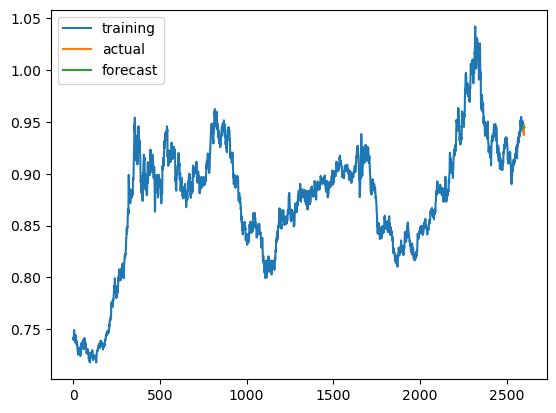

In [36]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [37]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [38]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(len(filepath)):
    best_parameters.append(fine_tune(df_train[i]))

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

In [39]:
print(best_parameters)

[(5, 2, 5), (2, 1, 5), (5, 1, 5)]


In [40]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

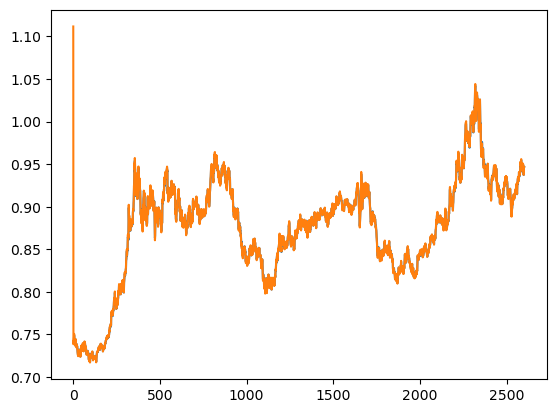

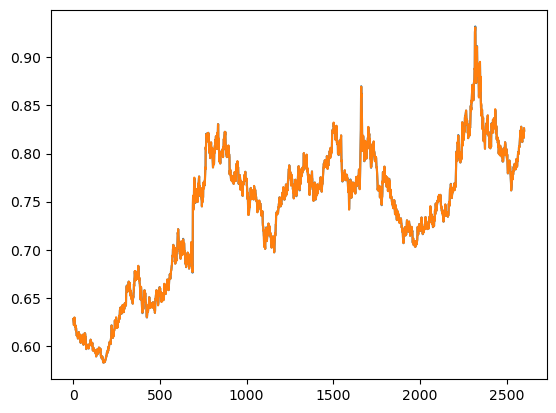

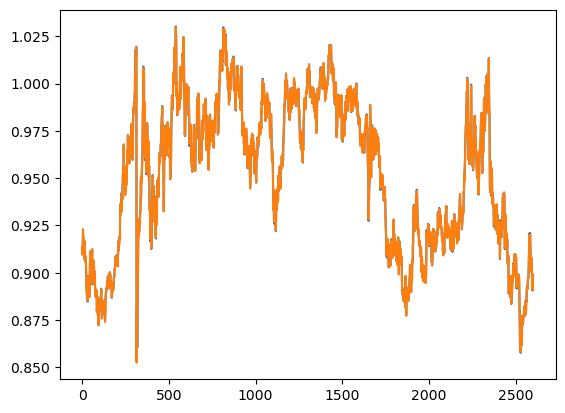

In [41]:
models=[]
for i in range(len(filepath)):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [42]:
ARIMA_predictions=[]
for i in range(len(filepath)):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [43]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

In [44]:
true_rate=[]
for i in range(len(filepath)):
    true_rate.append(np.array(df_test[i]).squeeze())

In [45]:
true_rate=np.array(true_rate)
true_rate

array([[0.94675, 0.94206, 0.94526, 0.94455, 0.9417 ],
       [0.82551, 0.82198, 0.8229 , 0.82087, 0.82022],
       [0.9024 , 0.90206, 0.9098 , 0.90555, 0.9061 ]])

In [92]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][i])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [93]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

1001.7737682644939 1009.1929376141054


In [94]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

MSE between the max profit computed via ARIMA and the actual profit is: 55.04407383821442


# Multivariate SARIMA

In [130]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [115]:
df_test

[         rate
 2605  0.94675
 2606  0.94206
 2607  0.94526
 2608  0.94455
 2609  0.94170,
          rate
 2605  0.82551
 2606  0.82198
 2607  0.82290
 2608  0.82087
 2609  0.82022,
          rate
 2605  0.90240
 2606  0.90206
 2607  0.90980
 2608  0.90555
 2609  0.90610]

In [122]:
df_combined = [pd.concat([train_df, test_df]) for train_df, test_df in zip(df_train, df_test)]
df_combined[0]

,rate
0,0.74107
1,0.73981
2,0.74222
3,0.73975
4,0.74576
...,...
2605,0.94675
2606,0.94206
2607,0.94526
2608,0.94455


In [193]:
usd_eur_rate = np.array(df_combined[0]["rate"])
usd_gbp_rate = np.array(df_combined[1]["rate"])
usd_chf_rate = np.array(df_combined[2]["rate"])
selected_dates_val = pd.to_datetime(df_temp['date'][:-5])
usd_eur_series = pd.Series(usd_eur_rate, index=selected_dates)
usd_gbp_series = pd.Series(usd_gbp_rate, index=selected_dates)
usd_chf_series = pd.Series(usd_chf_rate, index=selected_dates)
exog_data_val = pd.DataFrame({'Oil_Price': oil_price[:-5], 'Gold_Price': gold_price[:-5], 'Stock_Prices': stock_price[:-5]}, index=selected_dates_val)

## Hyper parameter tunning 

In [200]:
def fine_tune(df):
    #split dataset
    train_size=df.shape[0] - 5

    train=df[:train_size]
    val=df[train_size:]

    trainSeries = pd.Series(train, index=selected_dates_val)
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in [5,7,11]:
        for d in range(1,3):
            for q in [0,3,7]:
                model = SARIMAX(trainSeries, exog=exog_data_val, order=(p,d,q))
                model_fit = model.fit()
                forecast = model_fit.get_forecast(steps=5, exog=exog_data_val.iloc[-5:])
                val_predictions = forecast.predicted_mean
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [ ]:
best_parameters=[]
for i in [usd_eur_rate, usd_gbp_rate, usd_chf_rate]:
    best_parameters.append(fine_tune(i))

In [202]:
usd_eur_rate = np.array(df_combined[0]["rate"])
usd_gbp_rate = np.array(df_combined[1]["rate"])
usd_chf_rate = np.array(df_combined[2]["rate"])
selected_dates = pd.to_datetime(df_temp['date'])
selected_dates_val = pd.to_datetime(df_temp['date'][:-5])
usd_eur_series = pd.Series(usd_eur_rate, index=selected_dates)
usd_gbp_series = pd.Series(usd_gbp_rate, index=selected_dates)
usd_chf_series = pd.Series(usd_chf_rate, index=selected_dates)
exog_data = pd.DataFrame({'Oil_Price': oil_price, 'Gold_Price': gold_price, 'Stock_Prices': stock_price}, index=selected_dates)

In [ ]:
model = SARIMAX(usd_eur_series, exog=exog_data, order=(10,2,7))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_eur_rate = forecast.predicted_mean
predicted_usd_eur_rate

In [ ]:
model = SARIMAX(usd_gbp_series, exog=exog_data, order=(10,2,0))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_gbp_rate = forecast.predicted_mean
predicted_usd_gbp_rate

In [ ]:
model = SARIMAX(usd_chf_series, exog=exog_data, order=(5,1,0))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_chf_rate = forecast.predicted_mean
predicted_usd_chf_rate

In [ ]:
multi_S_predict_profit = get_max_profit(np.array([predicted_usd_eur_rate, predicted_usd_gbp_rate, predicted_usd_chf_rate]))
multi_S_predict_profit

# SARIMA

In [32]:
#seperates data set
!pip3 install pmdarima 
from pmdarima import auto_arima
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83559D+00    |proj g|=  6.63358D+01


 This problem is unconstrained.



At iterate    5    f= -3.89769D+00    |proj g|=  1.08725D-01

At iterate   10    f= -3.89859D+00    |proj g|=  1.05096D+01

At iterate   15    f= -3.90958D+00    |proj g|=  3.61286D+00

At iterate   20    f= -3.91371D+00    |proj g|=  1.62800D+01

At iterate   25    f= -3.95780D+00    |proj g|=  1.28531D+00

At iterate   30    f= -3.95977D+00    |proj g|=  2.02735D+00

At iterate   35    f= -3.96058D+00    |proj g|=  5.67839D-02

At iterate   40    f= -3.96061D+00    |proj g|=  7.85371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     59      1     0     0   3.693D-02  -3.961D+00
  F =  -3.96060762857

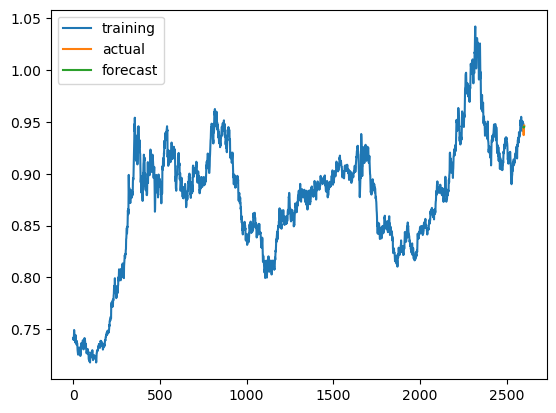

In [33]:
# train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# initial parameters
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
result = sarima.fit()
train_prediction = result.predict()
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Error Calculation

In [34]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(result.predict(),train)
val_mse = mean_squared_error(val_predictions, val)

## Fine tuning

In [35]:
def get_best_model_sarima(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q, optimal_P, optimal_D, optimal_Q, M=best_parameter
    model =  SARIMAX(train, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P,optimal_D,optimal_Q,M))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [36]:
def fine_tune_sarima(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    auto_para = auto_arima(train, start_p=1, start_q=1,
                          max_p=4, max_q=4, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          stepwise=True)
    
    non_s = auto_para.order
    seasonal_part = auto_para.seasonal_order
    
    return non_s[0],non_s[1],non_s[2], seasonal_part[0], seasonal_part[1], seasonal_part[2],seasonal_part[3]
    
    
    #fine-tuning
    
    
    
#     min_val_mse=1e9
#     p_optimized=1
#     d_optimized=1
#     q_optimized=1
#     for p in range(0,2):
#         for d in range(0,2):
#             for q in range(0,2):
#                 for P in range(0,2):
#                     for D in range(0,2):
#                         for Q in range(0,2):
#                             for M in range()
#                             model = SARIMAX(train, order=(p, d, q), seasonal_order=(P,D,Q,12))
#                             result = model.fit()
#                             train_predictions = result.predict(start=1, end=train.shape[0])
#                             val_predictions = result.get_forecast(len(val)).predicted_mean
#                             train_mse = mean_squared_error(train_predictions,train)
#                             val_mse = mean_squared_error(val_predictions, val)
#                             if (val_mse<min_val_mse):
#                                 min_val_mse=val_mse
#                                 p_optimized=p
#                                 q_optimized=q
#                                 d_optimized=d
#                             print(f"p={p},d={d},q={q}:")
#                             print("train_MSE:", train_mse)
#                             print("val_MSE:", val_mse)
#                             print("-------------------------------------------------------------")

#     smallest_error = -1
#     for q in range(1, 3):
#         for d in range(1, 3):
#             for p in range(1, 3):
#                 sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p,d,q,12))
#                 sarima_model.fit()
#                 train_prediction = result.predict()
#                 val_predictions = result.get_forecast(len(val)).predicted_mean
#                 if (smallest_error == -1):
#                     smallest_error = mean_squared_error(val_predictions, val)
#                 else:
#                     err = mean_squared_error(val_predictions, val)
#                     if (err < smallest_error):
#                         smallest_error = err
#                         q_optimized = q
#                         d_optimized = d
#                         p_optimized = p
    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-20267.157, Time=1.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-18843.951, Time=0.65 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-19594.526, Time=1.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-20269.561, Time=0.99 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-18842.484, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=5.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-20381.407, Time=3.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=31.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-20412.022, Time=4.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-20371.749, Time=4.34 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.44 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-20381.404, Time=3.85 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-20378.994, Time=7.65 sec
 ARIMA(0,1,0)(0,1,

 This problem is unconstrained.



At iterate    5    f= -3.92568D+00    |proj g|=  2.07435D+00

At iterate   10    f= -3.93057D+00    |proj g|=  9.81310D+00

At iterate   15    f= -3.93124D+00    |proj g|=  4.60754D-01

At iterate   20    f= -3.94942D+00    |proj g|=  7.96915D+00

At iterate   25    f= -3.95987D+00    |proj g|=  5.21349D-01

At iterate   30    f= -3.96055D+00    |proj g|=  1.00671D+00

At iterate   35    f= -3.96058D+00    |proj g|=  4.90861D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     58      1     0     0   2.552D-01  -3.961D+00
  F =  -3.9605818602933152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

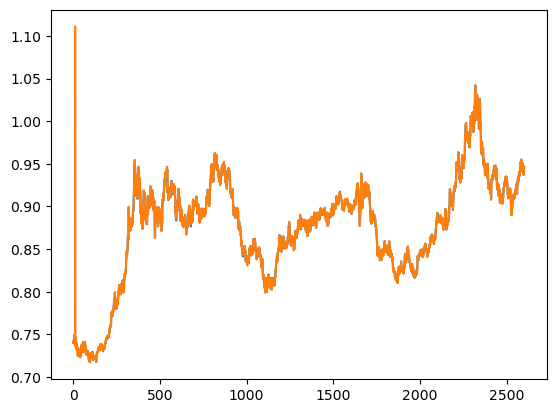

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79095D+00    |proj g|=  5.26071D+01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     29      1     0     0   1.756D-01  -3.827D+00
  F =  -3.8269232167386185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


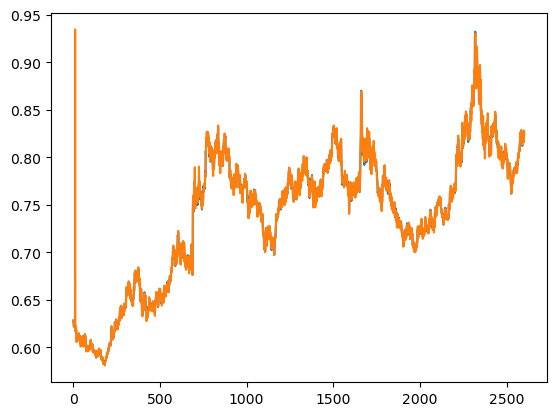

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.68929D+00    |proj g|=  1.91836D+01


 This problem is unconstrained.



At iterate    5    f= -3.69318D+00    |proj g|=  2.31641D-01

At iterate   10    f= -3.69344D+00    |proj g|=  4.92360D+00

At iterate   15    f= -3.69651D+00    |proj g|=  1.35097D+00

At iterate   20    f= -3.69655D+00    |proj g|=  4.53768D-01

At iterate   25    f= -3.69894D+00    |proj g|=  2.72936D+00

At iterate   30    f= -3.72315D+00    |proj g|=  8.88460D+00

At iterate   35    f= -3.73002D+00    |proj g|=  1.33412D+00

At iterate   40    f= -3.73034D+00    |proj g|=  2.62141D-01

At iterate   45    f= -3.73038D+00    |proj g|=  4.25174D-02

At iterate   50    f= -3.73039D+00    |proj g|=  1.55104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yujunlu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


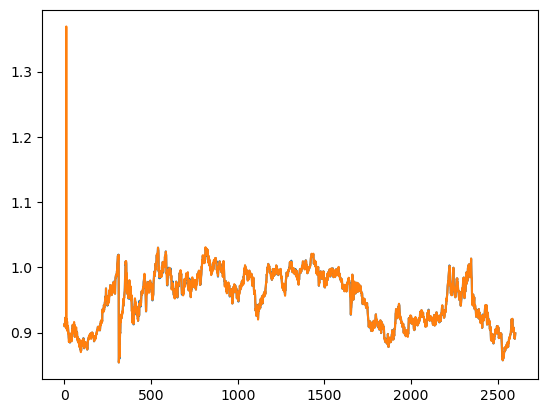

In [37]:
#find best hyper parameters for each dataset
best_parameters_sarima=[]
for i in range(3):
    best_parameters_sarima.append(fine_tune_sarima(df_train[i]))

models_sarima=[]
for i in range(3):
    models_sarima.append(get_best_model_sarima(df_train[i],best_parameters_sarima[i]))


In [38]:
SARIMA_predictions=[]
for i in range(3):
    SARIMA_predictions.append(models_sarima[i].get_forecast(len(df_test[i])).predicted_mean)

In [39]:
print(SARIMA_predictions)

[array([0.9467921 , 0.9472658 , 0.94737167, 0.94728962, 0.94730988]), array([0.82426161, 0.82830382, 0.82880019, 0.82638128, 0.82741682]), array([0.89888407, 0.89907818, 0.89915951, 0.89899474, 0.89799892])]


# Model Ensembling

In [56]:
pred_prophet=np.array(pred_prophet)
pred_prophet

array([[0.96006805, 0.96061385, 0.96100468, 0.96175484, 0.96228176],
       [0.84645936, 0.84680116, 0.84660925, 0.84664327, 0.84709535],
       [0.91868523, 0.91901172, 0.91958416, 0.91940545, 0.92011661]])

In [57]:
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

In [58]:
SARIMA_predictions=np.array(SARIMA_predictions)
SARIMA_predictions

array([[0.9478693 , 0.94944661, 0.95207225, 0.9489543 , 0.94797828],
       [0.82307685, 0.82645706, 0.82830086, 0.82590853, 0.82749819],
       [0.89886835, 0.90080861, 0.90245678, 0.89927338, 0.89982548]])

In [59]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weights = []
bias=[]
for i in range(len(filepath)):
    x1=pred_prophet[i]
    x2=ARIMA_predictions[i]
    x3=SARIMA_predictions[i]

    X_train = np.column_stack((x1, x2, x3))
    y_train = true_rate[i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    weights.append(model.coef_)
    bias.append(model.intercept_)

In [60]:
print(weights)
print(bias)

[array([-7.91138848, 10.15216378, -2.22973076]), array([-2.09151685,  4.87707134, -0.41185163]), array([2.19910042, 2.44612109, 1.0654471 ])]
[1.043230319594007, -1.0836114440110407, -4.275642101704065]


## Re-train on the whole train dataset

In [61]:
#prophet re-train
prophet_midterm_models = []

for curve_data in df_all_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # print(future_dates)
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_midterm_models.append((model, forecast))

20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing
20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
pred_prophet_midterm = [prophet_midterm_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_midterm_models))]

In [63]:
pred_prophet_midterm=np.array(pred_prophet_midterm)
pred_prophet_midterm

array([[0.9609852 , 0.96155656, 0.9619361 , 0.96260668, 0.96301525],
       [0.84504868, 0.84539674, 0.84517614, 0.84514294, 0.84550422],
       [0.9187741 , 0.91957928, 0.91996934, 0.92055842, 0.92037557]])

In [64]:
#ARIMA re-train
pred_ARIMA_midterm=[]
for i in range(len(filepath)):
    train=np.array(df_raw[i]['rate'])
    optimal_p, optimal_d, optimal_q=best_parameters[i]
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()
    test_predicionts = result.get_forecast(5).predicted_mean
    pred_ARIMA_midterm.append(test_predicionts)

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
pred_ARIMA_midterm=np.array(pred_ARIMA_midterm)
pred_ARIMA_midterm

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [66]:
#SARIMA re-train
pred_SARIMA_midterm=[]
for i in range(len(filepath)):
    train=np.array(df_raw[i]['rate'])
    optimal_p, optimal_d, optimal_q=best_parameters[i]
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
    result = model.fit()
    test_predicionts = result.get_forecast(5).predicted_mean
    pred_SARIMA_midterm.append(test_predicionts)

In [67]:
pred_SARIMA_midterm=np.array(pred_SARIMA_midterm)
pred_SARIMA_midterm

array([[0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

## Combine results

In [68]:
weights

[array([-7.91138848, 10.15216378, -2.22973076]),
 array([-2.09151685,  4.87707134, -0.41185163]),
 array([2.19910042, 2.44612109, 1.0654471 ])]

In [69]:
pred_prophet_midterm

array([[0.9609852 , 0.96155656, 0.9619361 , 0.96260668, 0.96301525],
       [0.84504868, 0.84539674, 0.84517614, 0.84514294, 0.84550422],
       [0.9187741 , 0.91957928, 0.91996934, 0.92055842, 0.92037557]])

In [70]:
pred_ARIMA_midterm

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [71]:
pred_SARIMA_midterm

array([[0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [72]:
final_pred_midterm=[]
for i in range(3):
    final_pred_midterm.append(pred_prophet_midterm[i]*weights[i][0]+pred_ARIMA_midterm[i]*weights[i][1]+pred_SARIMA_midterm[i]*weights[i][2]+bias[i])
final_pred_midterm

[array([0.98493638, 0.98068411, 0.97971634, 0.97304409, 0.97168247]),
 array([0.77566142, 0.77586448, 0.77759436, 0.77847658, 0.77791867]),
 array([0.92666619, 0.92933135, 0.92836651, 0.92893724, 0.92819183])]

Currently, we have not yet found a good way to do model ensembling.  
It's obvious that Linear Regression is a bad approach.

# Compute max profit using only ARIMA

In [73]:
pred_ARIMA_midterm=np.concatenate((pred_ARIMA_midterm,(pred_ARIMA_midterm[1]/pred_ARIMA_midterm[0]).reshape(1,5)))
pred_ARIMA_midterm=np.concatenate((pred_ARIMA_midterm,(pred_ARIMA_midterm[2]/pred_ARIMA_midterm[1]).reshape(1,5)))
pred_ARIMA_midterm

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.87050544, 0.8706548 , 0.87080443, 0.87112917, 0.87101294],
       [1.10481025, 1.1048347 , 1.10391099, 1.10345881, 1.10329629]])

In [74]:
# def max_profit(exchanges):
#     # Compute max profit can achieve in 5 days
#     exchanges = np.array(exchanges)
#     assert exchanges.shape == (5, 5)


#     # Calculate based on USD value each day
#     asset_value = 1000
#     asset_type = 0


#     # We can buy / sell 4 times in 5 days
#     for i in range(4):
#         data = exchanges[i]
#         conversion = get_best_conversion(data)
#         data_next = exchanges[i + 1]
#         # USD, EUR, GBP, CHF
#         values = np.array([1, 1 / data[0], 1 / data[3], 1 / data[4]])
#         next_values = np.array([1, 1 / data_next[0], 1 / data_next[3], 1 / data_next[4]])
#         # print(values)
#         # print(next_values)
#         pct_change = next_values / values
#         # print(pct_change)
#         next_asset_type = np.argmax(pct_change)
#         # print("Next most valuable exchange", next_asset_type)
#         next_asset_value = asset_value * conversion[asset_type][next_asset_type]


#     asset_value = next_asset_value
#     asset_type = next_asset_type
#     # print(asset_value)
#     # print(asset_type)
#     # print("-------------")


#     # Calculate final value in usd
#     data = exchanges[4]
#     conversion = get_best_conversion(data)
#     usd_value = asset_value * conversion[asset_type][0]


#     return usd_value - 1000

# def get_best_conversion(data):
#     # USD, EUR, GBP, CHF
#     conversion = [[-1] * 4 for i in range(4)]
#     for i in range(4):
#         conversion[i][i] = 1
#         conversion[0][1] = data[0]
#         conversion[0][2] = data[0] * data[1]
#         conversion[0][3] = data[4]
#         conversion[1][2] = data[1]
#         conversion[1][3] = data[1] * data[2]
#         conversion[2][3] = data[2]


#     for i in range(4):
#         for j in range(i + 1, 4):
#             conversion[j][i] = 1 / conversion[i][j]


#     return conversion

In [79]:
exchange_path=[]
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][i])
        max_rate_increase=np.max(rate_increase)
        exchange_path.append(np.argmax(rate_increase))
        principal*=max_rate_increase
    return principal-1000

In [80]:
predict_profit=get_max_profit(pred_ARIMA_midterm)

In [81]:
#0:USD-->USD 1:USD-->GBP 2:USD-->GBP 3:USD-->CHF
exchange_path

[3, 2, 2, 1]

This means we shall exchange USD to CHF on Monday.  
Then we exchange USD to GBP on Tuesday and Wednesday.
Finally we exchange USD to GBP on Thursday

In [82]:
print(f"The max profit we predict is {predict_profit}")

The max profit we predict is 0.8996934984260179


# Compared to ground-truth data

In [83]:
filepath_true=['USDEUR=X_true.csv','USDGBP=X_true.csv','USDCHF=X_true.csv']

In [86]:
true_market=[]
for path in filepath_true:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    true_market.append(np.array(df_temp))
true_market=np.array(true_market).squeeze()

In [87]:
true_market

array([[0.93178, 0.9327 , 0.93492, 0.93367, 0.93742],
       [0.80816, 0.81001, 0.81355, 0.814  , 0.81853],
       [0.89921, 0.8992 , 0.89997, 0.89908, 0.90315]])

In [90]:
exchange_path_true=[]
def get_max_profit_true(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][i])
        max_rate_increase=np.max(rate_increase)
        exchange_path_true.append(np.argmax(rate_increase))
        principal*=max_rate_increase
    return principal-1000
get_max_profit_true(true_market)

12.831617501484743

In [91]:
exchange_path_true

[2, 2, 2, 2]